✅ Datos cargados correctamente. Registros encontrados: 600
📈 Gráfica guardada: graficas_resultados\1_muertes.png


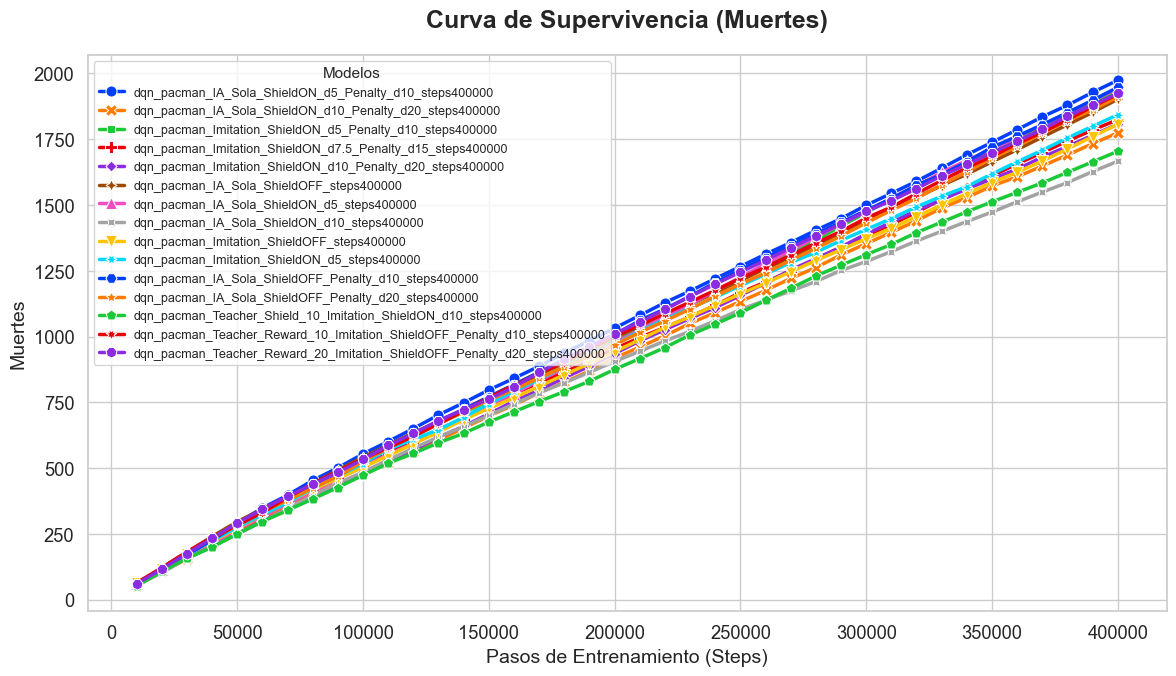

📈 Gráfica guardada: graficas_resultados\2_recompensa.png


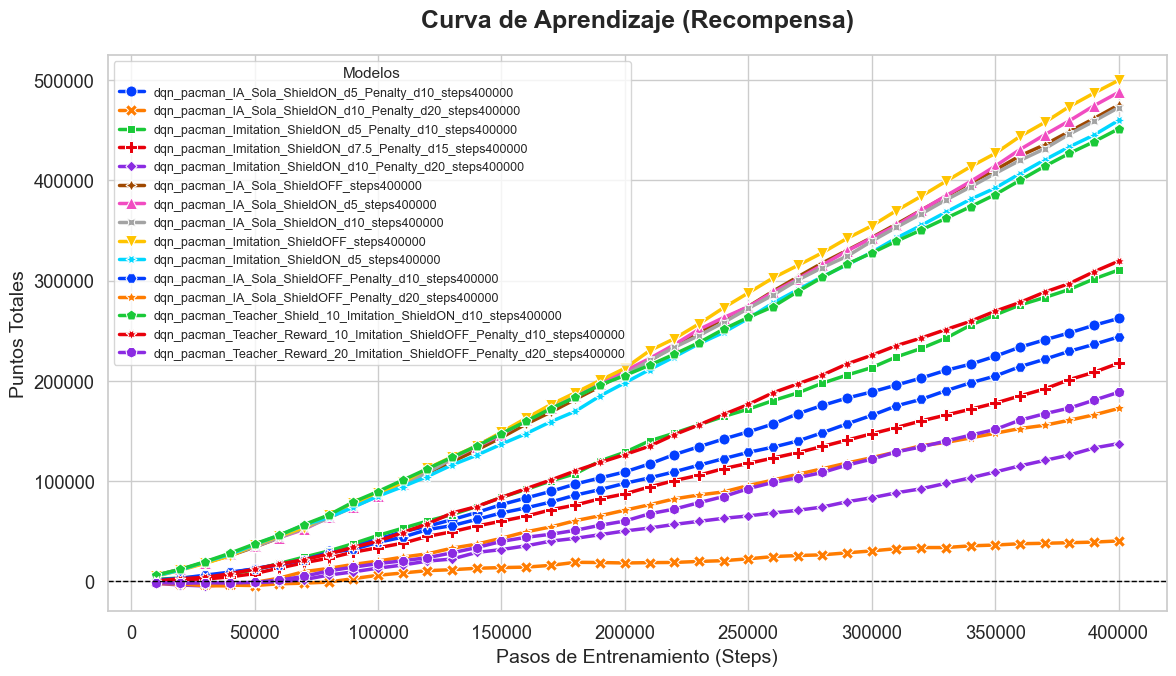

📈 Gráfica guardada: graficas_resultados\3_eficiencia.png


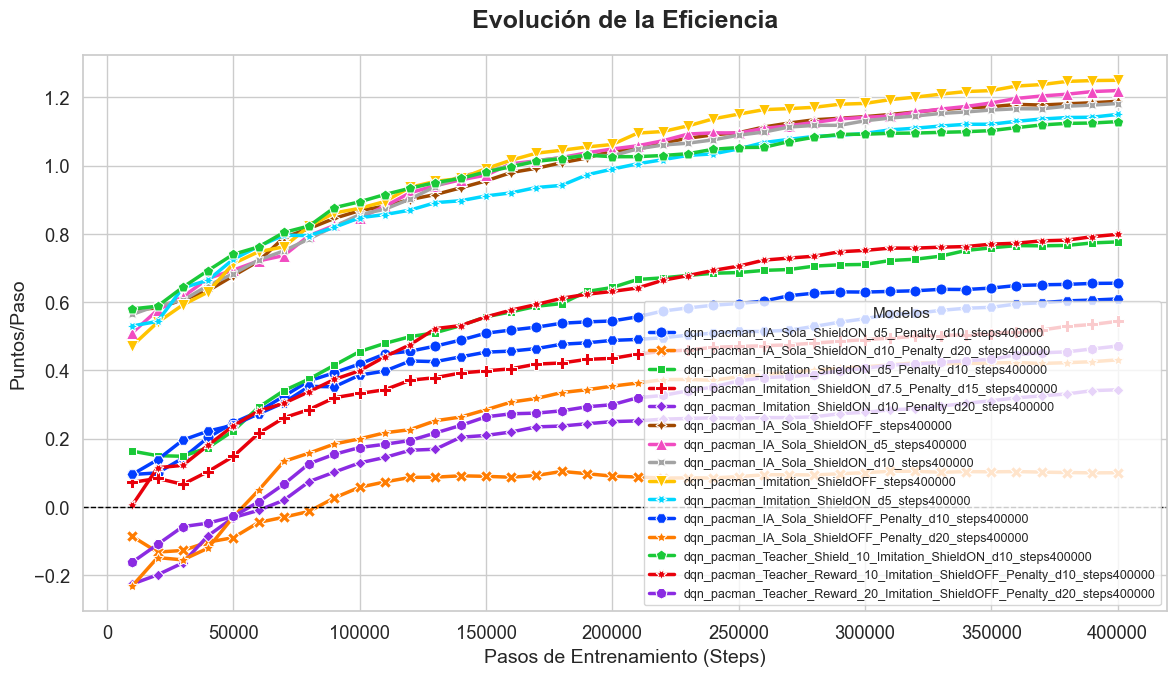

📈 Gráfica guardada: graficas_resultados\4_intervenciones.png


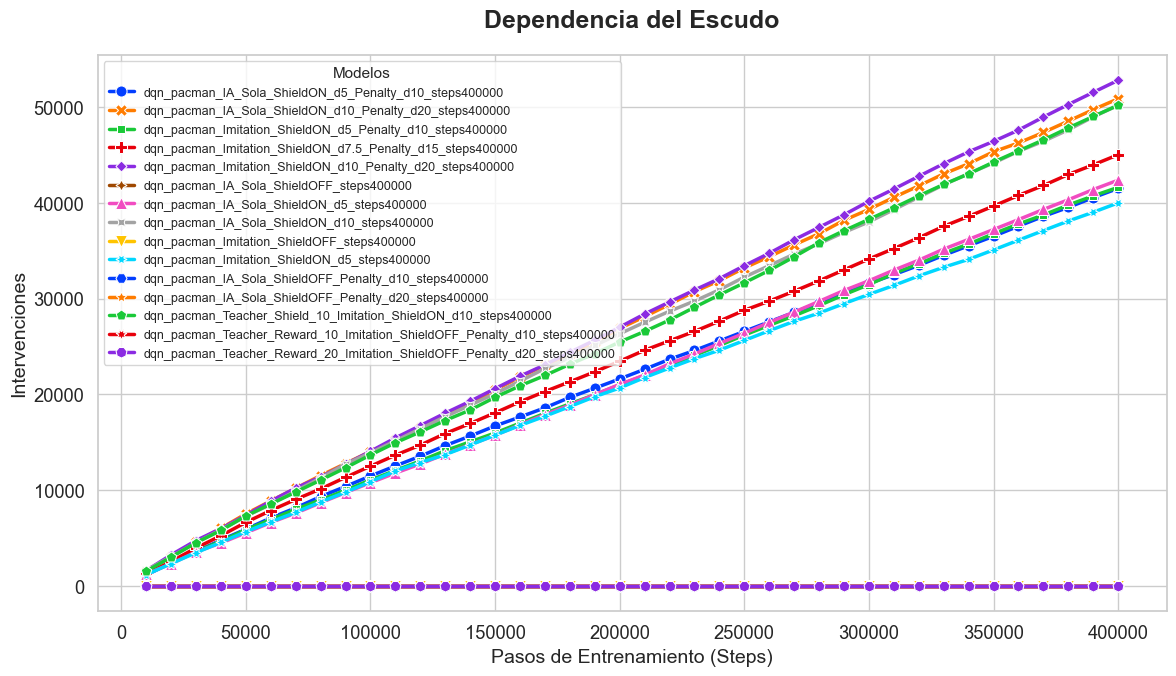

📈 Gráfica guardada: graficas_resultados\5_penalizaciones.png


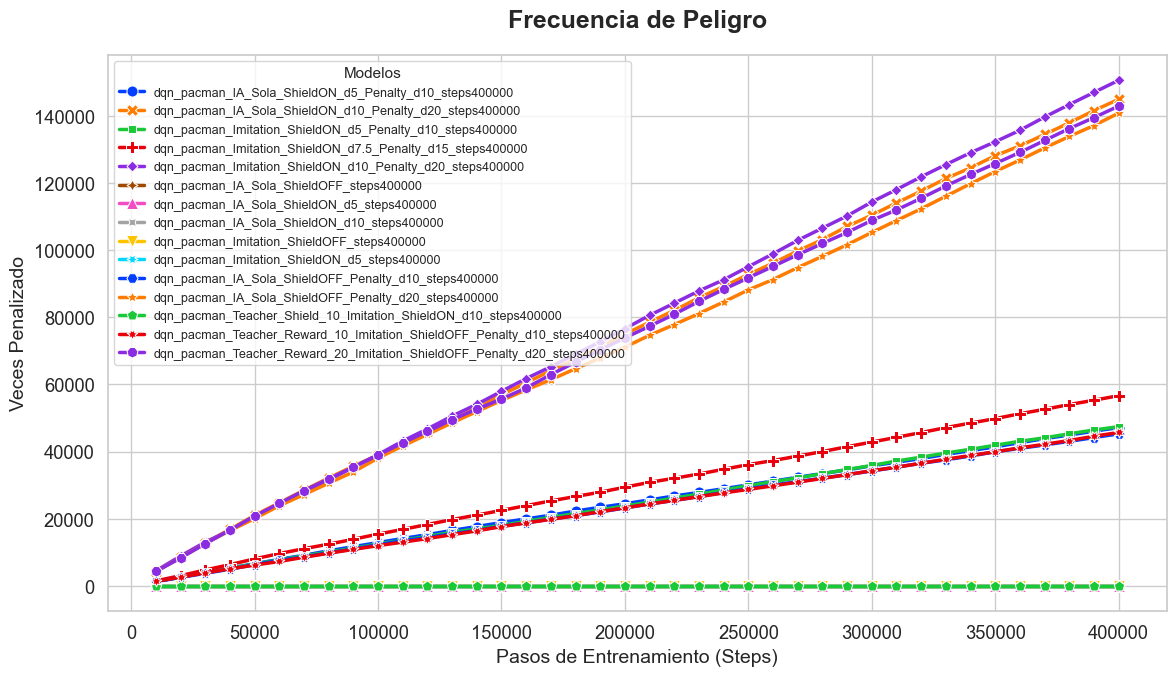


✨ Proceso finalizado.


In [3]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os

# ==========================================
# ⚙️ CONFIGURACIÓN
# ==========================================
ARCHIVO_CSV = "historial_training.csv"
CARPETA_GRAFICAS = "graficas_resultados"
ESTILO = "whitegrid"
PALETA_COLORES = "bright"

# ==========================================
# 🛠️ PREPARACIÓN
# ==========================================
def cargar_datos():
    if not os.path.exists(ARCHIVO_CSV):
        print(f"❌ Error: No se encuentra el archivo '{ARCHIVO_CSV}'")
        return None

    df = pd.read_csv(ARCHIVO_CSV)
    print(f"✅ Datos cargados correctamente. Registros encontrados: {len(df)}")
    return df

def configurar_estilo():
    sns.set_theme(style=ESTILO)
    sns.set_context("notebook", font_scale=1.2)
    if not os.path.exists(CARPETA_GRAFICAS):
        os.makedirs(CARPETA_GRAFICAS)

# ==========================================
# 📊 GENERACIÓN DE GRÁFICAS
# ==========================================
def graficar_metrica(df, eje_y, titulo, etiqueta_y, nombre_archivo):
    plt.figure(figsize=(12, 7))

    # Crear la gráfica
    ax = sns.lineplot(
        data=df,
        x="Step",
        y=eje_y,
        hue="Model_ID",
        style="Model_ID",
        markers=True,
        dashes=False,
        palette=PALETA_COLORES,
        linewidth=2.5,
        markersize=8
    )

    # Estética
    plt.title(titulo, fontsize=18, pad=20, fontweight='bold')
    plt.xlabel("Pasos de Entrenamiento (Steps)", fontsize=14)
    plt.ylabel(etiqueta_y, fontsize=14)

    # Línea base en 0
    if df[eje_y].min() < 0:
        plt.axhline(0, color='black', linewidth=1, linestyle='--')

    # Leyenda DENTRO de la gráfica (loc='best' busca el hueco libre automáticamente)
    # Reducimos un poco la fuente para que no ocupe todo si los nombres son largos
    plt.legend(title="Modelos", loc='best', fontsize=9, title_fontsize=11, framealpha=0.8)

    plt.tight_layout()

    # 1. Guardar archivo
    ruta = os.path.join(CARPETA_GRAFICAS, nombre_archivo)
    plt.savefig(ruta, dpi=300)
    print(f"📈 Gráfica guardada: {ruta}")

    # 2. MOSTRAR EN PANTALLA (Para Colab)
    plt.show()

    plt.close()

# ==========================================
# ▶️ EJECUCIÓN
# ==========================================
if __name__ == "__main__":
    configurar_estilo()
    df = cargar_datos()

    if df is not None:
        # Gráfica 1: Muertes
        graficar_metrica(df, "Deaths", "Curva de Supervivencia (Muertes)", "Muertes", "1_muertes.png")

        # Gráfica 2: Recompensa
        graficar_metrica(df, "Reward_Accumulated", "Curva de Aprendizaje (Recompensa)", "Puntos Totales", "2_recompensa.png")

        # Gráfica 3: Eficiencia
        graficar_metrica(df, "Efficiency", "Evolución de la Eficiencia", "Puntos/Paso", "3_eficiencia.png")

        # Gráfica 4: Intervenciones (si existen)
        if 'Interventions' in df.columns and df['Interventions'].sum() > 0:
            graficar_metrica(df, "Interventions", "Dependencia del Escudo", "Intervenciones", "4_intervenciones.png")

        # Gráfica 5: Penalizaciones (si existen)
        if 'Penalties' in df.columns and df['Penalties'].sum() > 0:
             graficar_metrica(df, "Penalties", "Frecuencia de Peligro", "Veces Penalizado", "5_penalizaciones.png")

        print("\n✨ Proceso finalizado.")

✅ Datos cargados correctamente. Registros totales: 600
📈 Gráfica guardada: graficas_resultados\1_muertes_tendencia.png


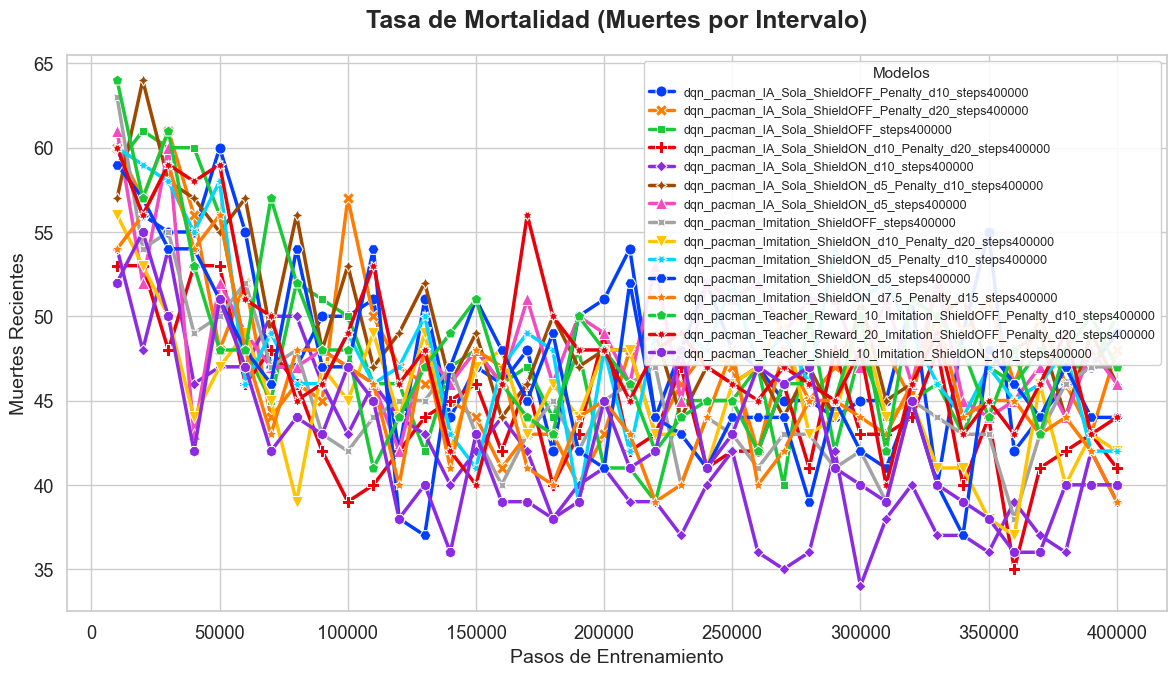

📈 Gráfica guardada: graficas_resultados\2_recompensa_tendencia.png


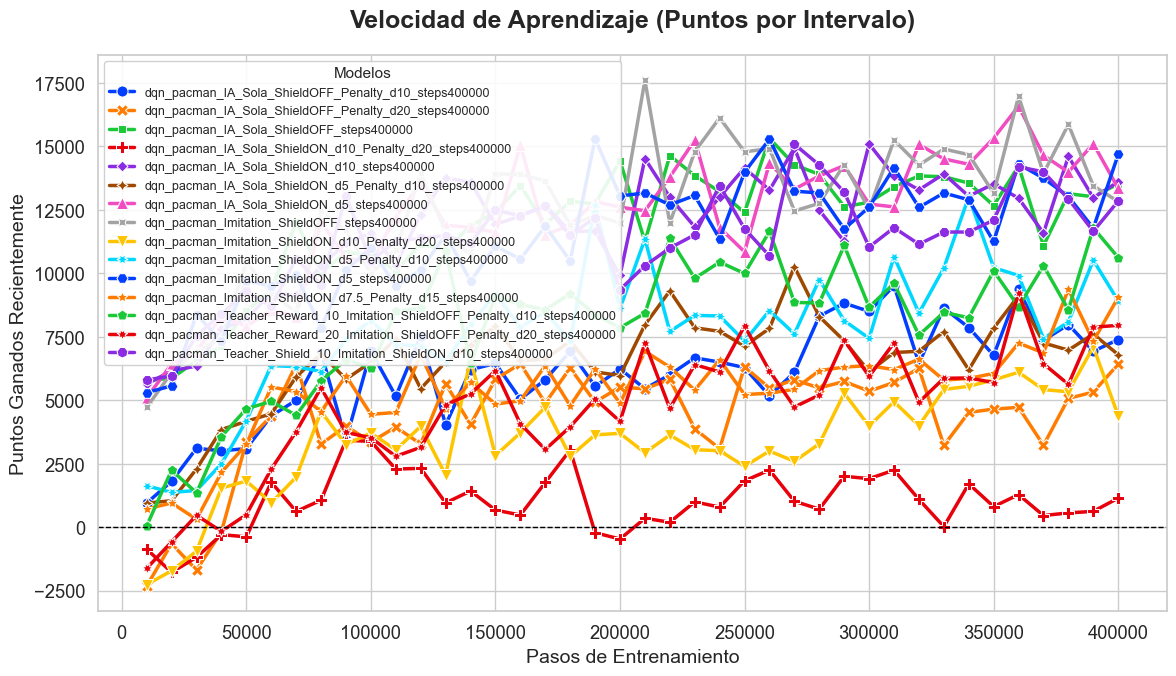

📈 Gráfica guardada: graficas_resultados\3_eficiencia_real.png


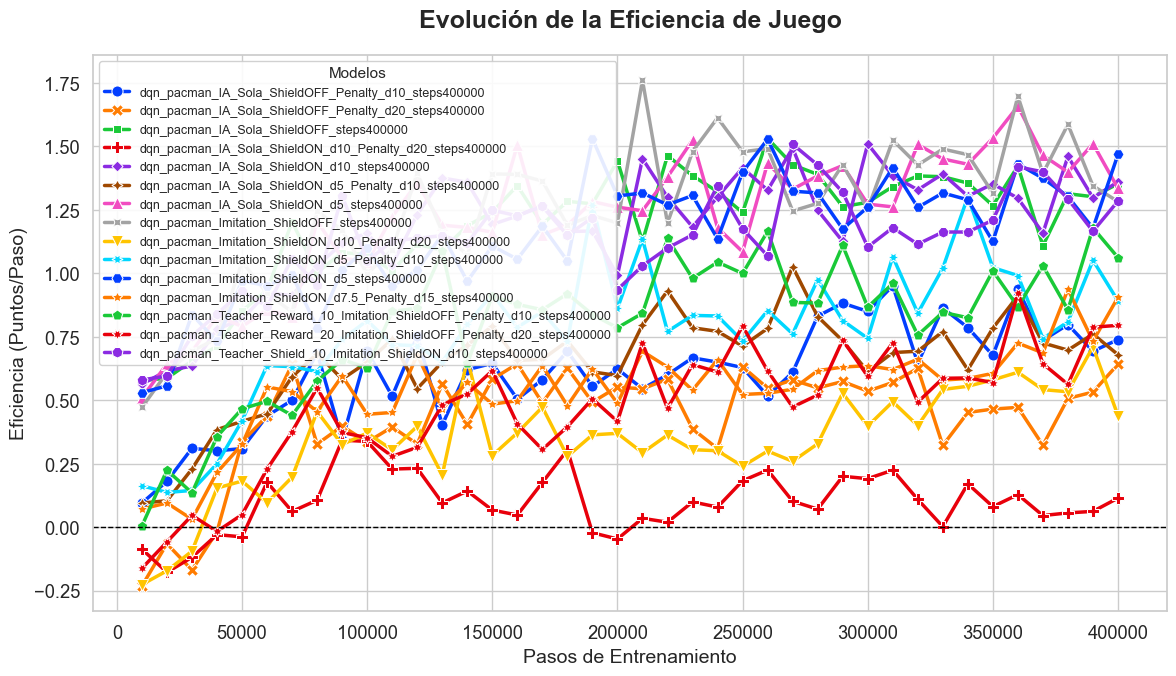

📈 Gráfica guardada: graficas_resultados\4_ppm_real.png


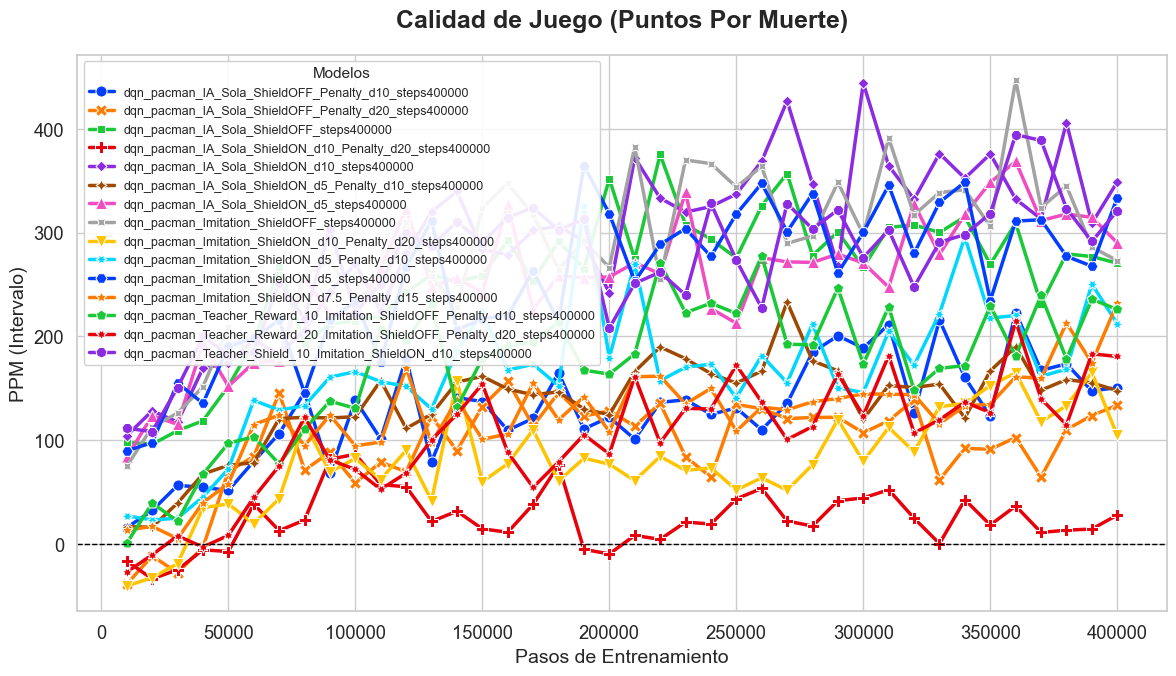

📈 Gráfica guardada: graficas_resultados\5_intervenciones.png


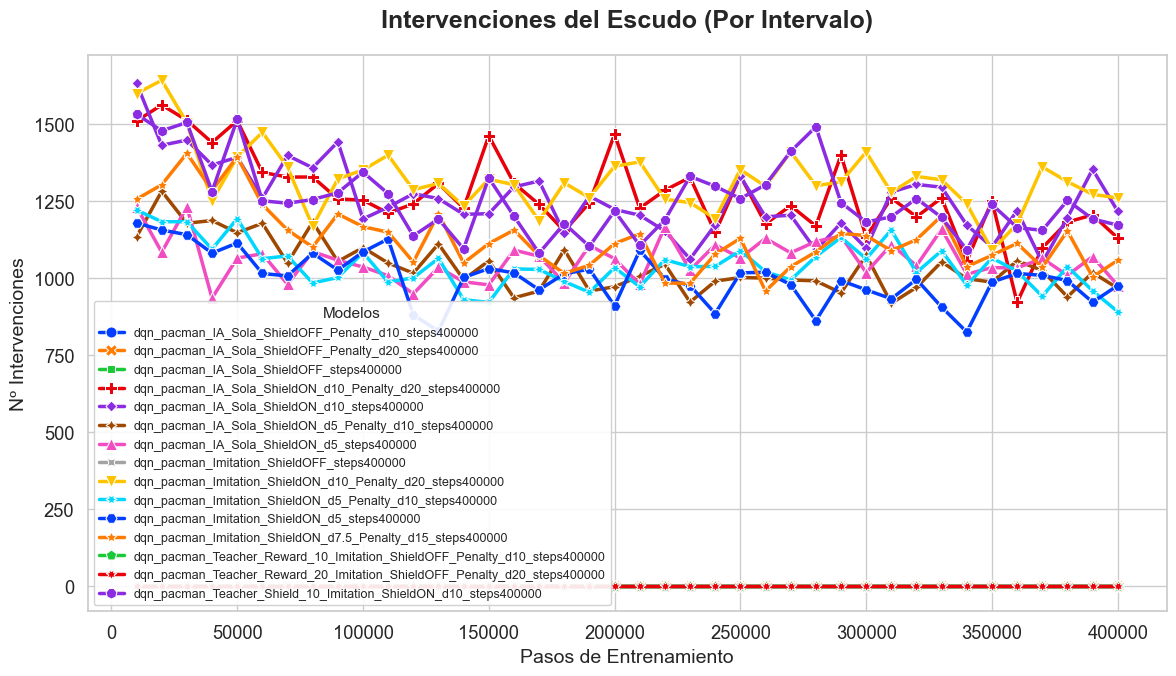


✨ ¡Gráficas diferenciales generadas con éxito!


In [4]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os

# ==========================================
# ⚙️ CONFIGURACIÓN
# ==========================================
ARCHIVO_CSV = "historial_training.csv"
CARPETA_GRAFICAS = "graficas_resultados"
ESTILO = "whitegrid"
PALETA_COLORES = "bright"

# ==========================================
# 🛠️ PREPARACIÓN Y CÁLCULO DIFERENCIAL
# ==========================================
def cargar_y_procesar_datos():
    if not os.path.exists(ARCHIVO_CSV):
        print(f"❌ Error: No se encuentra el archivo '{ARCHIVO_CSV}'")
        return None

    df = pd.read_csv(ARCHIVO_CSV)
    print(f"✅ Datos cargados correctamente. Registros totales: {len(df)}")

    # --- TRANSFORMACIÓN INTELIGENTE (ACUMULADO -> INTERVALO) ---
    # 1. Ordenamos por Modelo y Paso para que la resta tenga sentido
    df = df.sort_values(by=["Model_ID", "Step"])

    # 2. Calculamos cuántos pasos reales han pasado (Delta Step)
    # diff() resta la fila actual menos la anterior. fillna() arregla la primera fila.
    df["Delta_Step"] = df.groupby("Model_ID")["Step"].diff().fillna(df["Step"])

    # 3. Calculamos la diferencia real de métricas (Lo que pasó en ESTE intervalo)
    metricas_acumuladas = ["Deaths", "Reward_Accumulated", "Interventions", "Penalties"]

    for metrica in metricas_acumuladas:
        if metrica in df.columns:
            nombre_intervalo = f"Interval_{metrica}"
            # Restamos valor actual - valor anterior (agrupando por modelo)
            df[nombre_intervalo] = df.groupby("Model_ID")[metrica].diff()
            # El primer dato (NaN) se rellena con el valor original (asumimos que empieza en 0)
            df[nombre_intervalo] = df[nombre_intervalo].fillna(df[metrica])

    # 4. RECALCULAMOS EFICIENCIA Y PPM (Con datos del intervalo, no históricos)
    # Esto muestra "qué tan bien jugó en los últimos 5 minutos"

    # Eficiencia = Puntos ganados ahora / Pasos dados ahora
    if "Interval_Reward_Accumulated" in df.columns:
        df["Efficiency_Real"] = df["Interval_Reward_Accumulated"] / df["Delta_Step"]

    # PPM = Puntos ganados ahora / Muertes sufridas ahora
    if "Interval_Reward_Accumulated" in df.columns and "Interval_Deaths" in df.columns:
        df["PPM_Real"] = df.apply(
            lambda row: row["Interval_Reward_Accumulated"] / row["Interval_Deaths"]
            if row["Interval_Deaths"] > 0 else row["Interval_Reward_Accumulated"],
            axis=1
        )

    return df

def configurar_estilo():
    sns.set_theme(style=ESTILO)
    sns.set_context("notebook", font_scale=1.2)
    if not os.path.exists(CARPETA_GRAFICAS):
        os.makedirs(CARPETA_GRAFICAS)

# ==========================================
# 📊 GENERACIÓN DE GRÁFICAS
# ==========================================
def graficar_metrica(df, eje_y, titulo, etiqueta_y, nombre_archivo):
    plt.figure(figsize=(12, 7))

    if eje_y not in df.columns:
        return # Si no existe la columna, saltamos

    # Crear la gráfica
    ax = sns.lineplot(
        data=df,
        x="Step",
        y=eje_y,
        hue="Model_ID",
        style="Model_ID",
        markers=True,
        dashes=False,
        palette=PALETA_COLORES,
        linewidth=2.5,
        markersize=8
    )

    # Estética
    plt.title(titulo, fontsize=18, pad=20, fontweight='bold')
    plt.xlabel("Pasos de Entrenamiento", fontsize=14)
    plt.ylabel(etiqueta_y, fontsize=14)

    # Línea base en 0
    if df[eje_y].min() < 0:
        plt.axhline(0, color='black', linewidth=1, linestyle='--')

    # Leyenda DENTRO para no chafar la gráfica
    plt.legend(title="Modelos", loc='best', fontsize=9, title_fontsize=11, framealpha=0.9)

    plt.tight_layout()

    # Guardar y Mostrar
    ruta = os.path.join(CARPETA_GRAFICAS, nombre_archivo)
    plt.savefig(ruta, dpi=300)
    print(f"📈 Gráfica guardada: {ruta}")
    plt.show()
    plt.close()

# ==========================================
# ▶️ EJECUCIÓN
# ==========================================
if __name__ == "__main__":
    configurar_estilo()
    df_procesado = cargar_y_procesar_datos()

    if df_procesado is not None:
        # 1. Muertes (Intervalo): ¿Cuántas veces murió en los últimos X pasos?
        # Aquí queremos ver que la curva BAJE
        graficar_metrica(
            df_procesado,
            eje_y="Interval_Deaths",
            titulo="Tasa de Mortalidad (Muertes por Intervalo)",
            etiqueta_y="Muertes Recientes",
            nombre_archivo="1_muertes_tendencia.png"
        )

        # 2. Recompensa (Intervalo): ¿Cuántos puntos hizo en los últimos X pasos?
        # Aquí queremos ver que la curva SUBA
        graficar_metrica(
            df_procesado,
            eje_y="Interval_Reward_Accumulated",
            titulo="Velocidad de Aprendizaje (Puntos por Intervalo)",
            etiqueta_y="Puntos Ganados Recientemente",
            nombre_archivo="2_recompensa_tendencia.png"
        )

        # 3. Eficiencia Real: Puntos por paso en este momento
        graficar_metrica(
            df_procesado,
            eje_y="Efficiency_Real",
            titulo="Evolución de la Eficiencia de Juego",
            etiqueta_y="Eficiencia (Puntos/Paso)",
            nombre_archivo="3_eficiencia_real.png"
        )

        # 4. PPM Real: Puntos por muerte en este momento
        graficar_metrica(
            df_procesado,
            eje_y="PPM_Real",
            titulo="Calidad de Juego (Puntos Por Muerte)",
            etiqueta_y="PPM (Intervalo)",
            nombre_archivo="4_ppm_real.png"
        )

        # 5. Intervenciones (Solo si hay)
        if "Interval_Interventions" in df_procesado.columns and df_procesado["Interval_Interventions"].sum() > 0:
            graficar_metrica(
                df_procesado,
                eje_y="Interval_Interventions",
                titulo="Intervenciones del Escudo (Por Intervalo)",
                etiqueta_y="Nº Intervenciones",
                nombre_archivo="5_intervenciones.png"
            )

        print("\n✨ ¡Gráficas diferenciales generadas con éxito!")